In [1]:
import math
import time
import csv
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ['CUDA_VISIBLE_DEVICES']="1"
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

import numpy as np
import torch 
import torch.nn as nn
import torch.utils.data as data
import torch.nn.functional as F

torch.manual_seed(105)
np.random.seed(42)
np.set_printoptions(suppress=True, precision=3, threshold=40, linewidth=100, edgeitems=20)  

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True

import itertools
from tqdm import trange, tqdm
import matplotlib.pyplot as plt
import importlib
%matplotlib inline

'''
If curious about the detailed realization of certain module(s) below, try:
    print(*inspect.getsource(Module).split('\n'), sep='\n')
to get its source code.
'''
from Model.CGAN import Descriminator, Generator
from Train.train_CGAN import train
from Datas.data_load import dataset_append
from Test.Evaluate import evaluate
from utils.Save_and_load import save, load
from configs import opt, res_trans, RDevelop

In [2]:
def Model_def(opt, Channels, nf, device_train, load_model=False):
    '''
    Define (and load saved) model 
    '''
    netG = Generator(Channels, 5) 
    netD = Descriminator(1+1,nf)
    netG.initialize(); netD.initialize()
    if load_model:
        netG = load(netG, opt.load_model_path[0])
        netD = load(netD, opt.load_model_path[1])
    print(netG.parameters)
    print(netD.parameters)
    D_size = netD(torch.rand(1,2,*opt.Resmax)).shape
    
    if device_train.type == 'cuda':
        torch.cuda.empty_cache()
        netG = netG.to(device_train)
        netD = netD.to(device_train)
        print("allocated and reserved GPU memory: {}, {} (GiB)".format(
                torch.cuda.memory_allocated()/(1024**3), torch.cuda.memory_reserved()/(1024**3)))
    return netG, netD, D_size

In [3]:
Channels = [1, 8, 16, 32, 64, ]
nf = 4
device_train = torch.device('cuda:0') 
device_test = torch.device('cuda:0')
ckpt_name = ["CGAN-G.pth", "CGAN-D.pth"]
opt.load_model_path = [opt.modelpath+ckpt_name[i] for i in [0,1]]
netG, netD, D_size = Model_def(opt, Channels, nf, device_train)

Net Initialized
<bound method Module.parameters of Generator(
  (left_conv_1): ConvBlock(
    (block): Sequential(
      (0): Conv3d(1, 8, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
      (1): LeakyReLU(negative_slope=0.01, inplace=True)
      (2): Conv3d(8, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (3): LeakyReLU(negative_slope=0.01, inplace=True)
    )
  )
  (left_conv_2): ConvBlock(
    (block): Sequential(
      (0): Conv3d(8, 16, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
      (1): LeakyReLU(negative_slope=0.01, inplace=True)
      (2): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (3): LeakyReLU(negative_slope=0.01, inplace=True)
    )
  )
  (left_conv_3): ConvBlock(
    (block): Sequential(
      (0): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
      (1): LeakyReLU(negative_slope=0.01, inplace=True)
      (2): Conv3d(32, 32, kernel_size=(3, 3, 3), strid

In [4]:
dataset_train = dataset_append(opt, opt.dataidx_train, res_trans)
dataset_test = dataset_append(opt, opt.dataidx_test, res_trans)

  0%|          | 0/8 [00:00<?, ?it/s]

../dataset_train_v1/0000Acid_ini Read in 0.78 s
../dataset_train_v1/0000Inhibitor Read in 0.73 s
--> Mask 0 Read Complete, with dataset size: (1, 1, 80, 1000, 1000), 9 masks left ...

../dataset_train_v1/0001Acid_ini Read in 0.56 s
../dataset_train_v1/0001Inhibitor Read in 0.14 s
--> Mask 1 Read Complete, with dataset size: (2, 1, 80, 1000, 1000), 8 masks left ...

../dataset_train_v1/0002Acid_ini Read in 0.13 s
../dataset_train_v1/0002Inhibitor Read in 0.13 s
--> Mask 2 Read Complete, with dataset size: (3, 1, 80, 1000, 1000), 7 masks left ...

../dataset_train_v1/0003Acid_ini Read in 0.13 s
../dataset_train_v1/0003Inhibitor Read in 0.12 s
--> Mask 3 Read Complete, with dataset size: (4, 1, 80, 1000, 1000), 6 masks left ...

../dataset_train_v1/0004Acid_ini Read in 0.12 s
../dataset_train_v1/0004Inhibitor Read in 0.12 s
--> Mask 4 Read Complete, with dataset size: (5, 1, 80, 1000, 1000), 5 masks left ...

../dataset_train_v1/0005Acid_ini Read in 0.12 s
../dataset_train_v1/0005Inhibito

 12%|█▎        | 1/8 [00:24<02:48, 24.09s/it]

--> Mask 9 Read Complete, with dataset size: (10, 1, 80, 1000, 1000), 0 masks left ...

../dataset_train_v1/0010Acid_ini Read in 0.12 s
../dataset_train_v1/0010Inhibitor Read in 0.12 s
--> Mask 10 Read Complete, with dataset size: (1, 1, 80, 1000, 1000), 9 masks left ...

../dataset_train_v1/0011Acid_ini Read in 0.12 s
../dataset_train_v1/0011Inhibitor Read in 0.12 s
--> Mask 11 Read Complete, with dataset size: (2, 1, 80, 1000, 1000), 8 masks left ...

../dataset_train_v1/0012Acid_ini Read in 0.14 s
../dataset_train_v1/0012Inhibitor Read in 0.12 s
--> Mask 12 Read Complete, with dataset size: (3, 1, 80, 1000, 1000), 7 masks left ...

../dataset_train_v1/0013Acid_ini Read in 0.12 s
../dataset_train_v1/0013Inhibitor Read in 0.13 s
--> Mask 13 Read Complete, with dataset size: (4, 1, 80, 1000, 1000), 6 masks left ...

../dataset_train_v1/0014Acid_ini Read in 0.13 s
../dataset_train_v1/0014Inhibitor Read in 0.13 s
--> Mask 14 Read Complete, with dataset size: (5, 1, 80, 1000, 1000), 5 mas

 25%|██▌       | 2/8 [00:46<02:18, 23.14s/it]

--> Mask 19 Read Complete, with dataset size: (10, 1, 80, 1000, 1000), 0 masks left ...

../dataset_train_v1/0020Acid_ini Read in 0.13 s
../dataset_train_v1/0020Inhibitor Read in 0.13 s
--> Mask 20 Read Complete, with dataset size: (1, 1, 80, 1000, 1000), 9 masks left ...

../dataset_train_v1/0021Acid_ini Read in 0.12 s
../dataset_train_v1/0021Inhibitor Read in 0.13 s
--> Mask 21 Read Complete, with dataset size: (2, 1, 80, 1000, 1000), 8 masks left ...

../dataset_train_v1/0022Acid_ini Read in 0.12 s
../dataset_train_v1/0022Inhibitor Read in 0.12 s
--> Mask 22 Read Complete, with dataset size: (3, 1, 80, 1000, 1000), 7 masks left ...

../dataset_train_v1/0023Acid_ini Read in 0.13 s
../dataset_train_v1/0023Inhibitor Read in 0.13 s
--> Mask 23 Read Complete, with dataset size: (4, 1, 80, 1000, 1000), 6 masks left ...

../dataset_train_v1/0024Acid_ini Read in 0.12 s
../dataset_train_v1/0024Inhibitor Read in 0.12 s
--> Mask 24 Read Complete, with dataset size: (5, 1, 80, 1000, 1000), 5 ma

 38%|███▊      | 3/8 [01:09<01:54, 22.82s/it]

--> Mask 29 Read Complete, with dataset size: (10, 1, 80, 1000, 1000), 0 masks left ...

../dataset_train_v1/0030Acid_ini Read in 0.13 s
../dataset_train_v1/0030Inhibitor Read in 0.13 s
--> Mask 30 Read Complete, with dataset size: (1, 1, 80, 1000, 1000), 9 masks left ...

../dataset_train_v1/0031Acid_ini Read in 0.12 s
../dataset_train_v1/0031Inhibitor Read in 0.12 s
--> Mask 31 Read Complete, with dataset size: (2, 1, 80, 1000, 1000), 8 masks left ...

../dataset_train_v1/0032Acid_ini Read in 0.13 s
../dataset_train_v1/0032Inhibitor Read in 0.12 s
--> Mask 32 Read Complete, with dataset size: (3, 1, 80, 1000, 1000), 7 masks left ...

../dataset_train_v1/0033Acid_ini Read in 0.13 s
../dataset_train_v1/0033Inhibitor Read in 0.13 s
--> Mask 33 Read Complete, with dataset size: (4, 1, 80, 1000, 1000), 6 masks left ...

../dataset_train_v1/0034Acid_ini Read in 0.13 s
../dataset_train_v1/0034Inhibitor Read in 0.13 s
--> Mask 34 Read Complete, with dataset size: (5, 1, 80, 1000, 1000), 5 ma

 50%|█████     | 4/8 [01:31<01:30, 22.72s/it]

--> Mask 39 Read Complete, with dataset size: (10, 1, 80, 1000, 1000), 0 masks left ...

../dataset_train_v1/0040Acid_ini Read in 0.13 s
../dataset_train_v1/0040Inhibitor Read in 0.13 s
--> Mask 40 Read Complete, with dataset size: (1, 1, 80, 1000, 1000), 9 masks left ...

../dataset_train_v1/0041Acid_ini Read in 0.13 s
../dataset_train_v1/0041Inhibitor Read in 0.14 s
--> Mask 41 Read Complete, with dataset size: (2, 1, 80, 1000, 1000), 8 masks left ...

../dataset_train_v1/0042Acid_ini Read in 0.13 s
../dataset_train_v1/0042Inhibitor Read in 0.13 s
--> Mask 42 Read Complete, with dataset size: (3, 1, 80, 1000, 1000), 7 masks left ...

../dataset_train_v1/0043Acid_ini Read in 0.13 s
../dataset_train_v1/0043Inhibitor Read in 0.13 s
--> Mask 43 Read Complete, with dataset size: (4, 1, 80, 1000, 1000), 6 masks left ...

../dataset_train_v1/0044Acid_ini Read in 0.13 s
../dataset_train_v1/0044Inhibitor Read in 0.13 s
--> Mask 44 Read Complete, with dataset size: (5, 1, 80, 1000, 1000), 5 ma

 62%|██████▎   | 5/8 [01:54<01:08, 22.73s/it]

--> Mask 49 Read Complete, with dataset size: (10, 1, 80, 1000, 1000), 0 masks left ...

../dataset_train_v1/0050Acid_ini Read in 0.15 s
../dataset_train_v1/0050Inhibitor Read in 0.19 s
--> Mask 50 Read Complete, with dataset size: (1, 1, 80, 1000, 1000), 9 masks left ...

../dataset_train_v1/0051Acid_ini Read in 0.23 s
../dataset_train_v1/0051Inhibitor Read in 0.16 s
--> Mask 51 Read Complete, with dataset size: (2, 1, 80, 1000, 1000), 8 masks left ...

../dataset_train_v1/0052Acid_ini Read in 0.16 s
../dataset_train_v1/0052Inhibitor Read in 0.15 s
--> Mask 52 Read Complete, with dataset size: (3, 1, 80, 1000, 1000), 7 masks left ...

../dataset_train_v1/0053Acid_ini Read in 0.17 s
../dataset_train_v1/0053Inhibitor Read in 0.17 s
--> Mask 53 Read Complete, with dataset size: (4, 1, 80, 1000, 1000), 6 masks left ...

../dataset_train_v1/0054Acid_ini Read in 0.16 s
../dataset_train_v1/0054Inhibitor Read in 0.15 s
--> Mask 54 Read Complete, with dataset size: (5, 1, 80, 1000, 1000), 5 ma

 75%|███████▌  | 6/8 [02:20<00:47, 23.77s/it]

--> Mask 59 Read Complete, with dataset size: (10, 1, 80, 1000, 1000), 0 masks left ...

../dataset_train_v1/0060Acid_ini Read in 0.14 s
../dataset_train_v1/0060Inhibitor Read in 0.13 s
--> Mask 60 Read Complete, with dataset size: (1, 1, 80, 1000, 1000), 9 masks left ...

../dataset_train_v1/0061Acid_ini Read in 0.13 s
../dataset_train_v1/0061Inhibitor Read in 0.13 s
--> Mask 61 Read Complete, with dataset size: (2, 1, 80, 1000, 1000), 8 masks left ...

../dataset_train_v1/0062Acid_ini Read in 0.13 s
../dataset_train_v1/0062Inhibitor Read in 0.15 s
--> Mask 62 Read Complete, with dataset size: (3, 1, 80, 1000, 1000), 7 masks left ...

../dataset_train_v1/0063Acid_ini Read in 0.13 s
../dataset_train_v1/0063Inhibitor Read in 0.13 s
--> Mask 63 Read Complete, with dataset size: (4, 1, 80, 1000, 1000), 6 masks left ...

../dataset_train_v1/0064Acid_ini Read in 0.15 s
../dataset_train_v1/0064Inhibitor Read in 0.15 s
--> Mask 64 Read Complete, with dataset size: (5, 1, 80, 1000, 1000), 5 ma

 88%|████████▊ | 7/8 [02:43<00:23, 23.57s/it]

--> Mask 69 Read Complete, with dataset size: (10, 1, 80, 1000, 1000), 0 masks left ...

../dataset_train_v1/0070Acid_ini Read in 0.16 s
../dataset_train_v1/0070Inhibitor Read in 0.16 s
--> Mask 70 Read Complete, with dataset size: (1, 1, 80, 1000, 1000), 9 masks left ...

../dataset_train_v1/0071Acid_ini Read in 0.15 s
../dataset_train_v1/0071Inhibitor Read in 0.23 s
--> Mask 71 Read Complete, with dataset size: (2, 1, 80, 1000, 1000), 8 masks left ...

../dataset_train_v1/0072Acid_ini Read in 0.26 s
../dataset_train_v1/0072Inhibitor Read in 0.24 s
--> Mask 72 Read Complete, with dataset size: (3, 1, 80, 1000, 1000), 7 masks left ...

../dataset_train_v1/0073Acid_ini Read in 0.20 s
../dataset_train_v1/0073Inhibitor Read in 0.19 s
--> Mask 73 Read Complete, with dataset size: (4, 1, 80, 1000, 1000), 6 masks left ...

../dataset_train_v1/0074Acid_ini Read in 0.14 s
../dataset_train_v1/0074Inhibitor Read in 0.15 s
--> Mask 74 Read Complete, with dataset size: (5, 1, 80, 1000, 1000), 5 ma

100%|██████████| 8/8 [03:06<00:00, 23.31s/it]


--> Mask 79 Read Complete, with dataset size: (10, 1, 80, 1000, 1000), 0 masks left ...



  0%|          | 0/2 [00:00<?, ?it/s]

../dataset_train_v1/0080Acid_ini Read in 0.15 s
../dataset_train_v1/0080Inhibitor Read in 0.15 s
--> Mask 80 Read Complete, with dataset size: (1, 1, 80, 1000, 1000), 9 masks left ...

../dataset_train_v1/0081Acid_ini Read in 0.14 s
../dataset_train_v1/0081Inhibitor Read in 0.14 s
--> Mask 81 Read Complete, with dataset size: (2, 1, 80, 1000, 1000), 8 masks left ...

../dataset_train_v1/0082Acid_ini Read in 0.13 s
../dataset_train_v1/0082Inhibitor Read in 0.13 s
--> Mask 82 Read Complete, with dataset size: (3, 1, 80, 1000, 1000), 7 masks left ...

../dataset_train_v1/0083Acid_ini Read in 0.13 s
../dataset_train_v1/0083Inhibitor Read in 0.14 s
--> Mask 83 Read Complete, with dataset size: (4, 1, 80, 1000, 1000), 6 masks left ...

../dataset_train_v1/0084Acid_ini Read in 0.14 s
../dataset_train_v1/0084Inhibitor Read in 0.13 s
--> Mask 84 Read Complete, with dataset size: (5, 1, 80, 1000, 1000), 5 masks left ...

../dataset_train_v1/0085Acid_ini Read in 0.15 s
../dataset_train_v1/0085Inh

 50%|█████     | 1/2 [00:22<00:22, 22.79s/it]

--> Mask 89 Read Complete, with dataset size: (10, 1, 80, 1000, 1000), 0 masks left ...

../dataset_train_v1/0090Acid_ini Read in 0.14 s
../dataset_train_v1/0090Inhibitor Read in 0.13 s
--> Mask 90 Read Complete, with dataset size: (1, 1, 80, 1000, 1000), 9 masks left ...

../dataset_train_v1/0091Acid_ini Read in 0.13 s
../dataset_train_v1/0091Inhibitor Read in 0.13 s
--> Mask 91 Read Complete, with dataset size: (2, 1, 80, 1000, 1000), 8 masks left ...

../dataset_train_v1/0092Acid_ini Read in 0.13 s
../dataset_train_v1/0092Inhibitor Read in 0.13 s
--> Mask 92 Read Complete, with dataset size: (3, 1, 80, 1000, 1000), 7 masks left ...

../dataset_train_v1/0093Acid_ini Read in 0.13 s
../dataset_train_v1/0093Inhibitor Read in 0.12 s
--> Mask 93 Read Complete, with dataset size: (4, 1, 80, 1000, 1000), 6 masks left ...

../dataset_train_v1/0094Acid_ini Read in 0.15 s
../dataset_train_v1/0094Inhibitor Read in 0.14 s
--> Mask 94 Read Complete, with dataset size: (5, 1, 80, 1000, 1000), 5 ma

100%|██████████| 2/2 [00:45<00:00, 22.77s/it]

--> Mask 99 Read Complete, with dataset size: (10, 1, 80, 1000, 1000), 0 masks left ...



In [5]:
def opt_strategy(netG, netD, opt):
    optimizerD = torch.optim.Adam(netD.parameters(), lr = 3e-4,)# weight_decay=1e-4)
    optimizerG = torch.optim.Adam(netG.parameters(), lr = 1e-3,)
    schedulerG = torch.optim.lr_scheduler.StepLR(optimizerG, step_size=100, gamma=0.8)
    schedulerD = torch.optim.lr_scheduler.StepLR(optimizerD, step_size=100, gamma=0.8)
    return optimizerG, optimizerD, schedulerG, schedulerD

In [6]:
opt.epochs = 2000
optimizerG, optimizerD, schedulerG, schedulerD = opt_strategy(netG, netD, opt)
train_log, test_log = train(netG, netD, D_size, optimizerG, optimizerD, schedulerG, schedulerD, opt, dataset_train, 
                                           device_train, dataset_test, res_trans, ckpt_name, save_check=15)

if not os.path.exists(opt.load_model_path[0]):
    save(netD, opt.modelpath, ckpt_name[1])
    save(netG, opt.modelpath, ckpt_name[0])

  0%|          | 1/2000 [01:59<66:27:32, 119.69s/it]

Epoch 0 | LR: 1.00e-03 | Train Loss: 9.33e-01(G) 8.96e-03(D) | Test Loss: 1.77e+02, 2.62e-01, 586.24%


  1%|          | 21/2000 [30:30<48:11:00, 87.65s/it]

Epoch 20 | LR: 1.00e-03 | Train Loss: 1.09e-01(G) 1.22e-02(D) | Test Loss: 3.98e+01, 8.27e-02, 111.24%


  2%|▏         | 41/2000 [58:57<47:39:21, 87.58s/it]

Epoch 40 | LR: 1.00e-03 | Train Loss: 1.05e-01(G) 1.30e-02(D) | Test Loss: 3.61e+01, 7.47e-02, 107.27%


  3%|▎         | 61/2000 [1:27:26<47:10:14, 87.58s/it]

Epoch 60 | LR: 1.00e-03 | Train Loss: 7.06e-02(G) 1.36e-02(D) | Test Loss: 3.36e+01, 6.32e-02, 103.76%


  4%|▍         | 81/2000 [1:55:57<46:39:46, 87.54s/it]

Epoch 80 | LR: 1.00e-03 | Train Loss: 7.57e-02(G) 1.39e-02(D) | Test Loss: 2.94e+01, 6.95e-02, 102.88%


  5%|▌         | 101/2000 [2:24:30<46:18:45, 87.80s/it]

Epoch 100 | LR: 8.00e-04 | Train Loss: 4.59e-02(G) 1.42e-02(D) | Test Loss: 2.86e+01, 7.21e-02, 101.48%


  6%|▌         | 121/2000 [2:53:01<45:41:55, 87.55s/it]

Epoch 120 | LR: 8.00e-04 | Train Loss: 3.70e-02(G) 1.44e-02(D) | Test Loss: 2.73e+01, 8.72e-02, 100.32%


  7%|▋         | 141/2000 [3:21:34<45:19:00, 87.76s/it]

Epoch 140 | LR: 8.00e-04 | Train Loss: 4.21e-02(G) 1.45e-02(D) | Test Loss: 2.54e+01, 5.28e-02, 101.71%


  8%|▊         | 161/2000 [3:50:07<44:46:59, 87.67s/it]

Epoch 160 | LR: 8.00e-04 | Train Loss: 3.60e-02(G) 1.48e-02(D) | Test Loss: 2.44e+01, 5.40e-02, 101.21%


  9%|▉         | 181/2000 [4:18:34<44:07:23, 87.32s/it]

Epoch 180 | LR: 8.00e-04 | Train Loss: 3.68e-02(G) 1.49e-02(D) | Test Loss: 2.21e+01, 8.05e-02, 98.41%


 10%|█         | 201/2000 [4:47:04<43:40:20, 87.39s/it]

Epoch 200 | LR: 6.40e-04 | Train Loss: 4.03e-02(G) 1.50e-02(D) | Test Loss: 2.11e+01, 7.07e-02, 97.31%


 11%|█         | 221/2000 [5:15:36<43:16:41, 87.58s/it]

Epoch 220 | LR: 6.40e-04 | Train Loss: 1.79e-02(G) 1.51e-02(D) | Test Loss: 2.08e+01, 5.57e-02, 97.81%


 12%|█▏        | 241/2000 [5:44:05<42:42:26, 87.41s/it]

Epoch 240 | LR: 6.40e-04 | Train Loss: 4.01e-02(G) 1.52e-02(D) | Test Loss: 2.12e+01, 5.70e-02, 94.97%


 13%|█▎        | 261/2000 [6:12:38<42:25:18, 87.82s/it]

Epoch 260 | LR: 6.40e-04 | Train Loss: 3.36e-02(G) 1.52e-02(D) | Test Loss: 2.14e+01, 5.46e-02, 90.69%


 14%|█▍        | 281/2000 [6:41:10<41:55:43, 87.81s/it]

Epoch 280 | LR: 6.40e-04 | Train Loss: 2.41e-02(G) 1.53e-02(D) | Test Loss: 2.20e+01, 3.77e-02, 89.75%


 15%|█▌        | 301/2000 [7:09:45<41:25:10, 87.76s/it]

Epoch 300 | LR: 5.12e-04 | Train Loss: 1.60e-02(G) 1.53e-02(D) | Test Loss: 2.22e+01, 5.77e-02, 84.14%


 16%|█▌        | 321/2000 [7:38:18<40:51:58, 87.62s/it]

Epoch 320 | LR: 5.12e-04 | Train Loss: 3.08e-02(G) 1.54e-02(D) | Test Loss: 2.22e+01, 6.16e-02, 82.45%


 17%|█▋        | 341/2000 [8:06:53<40:20:57, 87.56s/it]

Epoch 340 | LR: 5.12e-04 | Train Loss: 3.36e-02(G) 1.54e-02(D) | Test Loss: 2.22e+01, 5.31e-02, 80.96%


 18%|█▊        | 361/2000 [8:35:25<39:52:36, 87.59s/it]

Epoch 360 | LR: 5.12e-04 | Train Loss: 2.76e-02(G) 1.54e-02(D) | Test Loss: 2.25e+01, 4.54e-02, 79.51%


 19%|█▉        | 381/2000 [9:03:52<39:10:22, 87.10s/it]

Epoch 380 | LR: 5.12e-04 | Train Loss: 2.31e-02(G) 1.55e-02(D) | Test Loss: 2.24e+01, 5.32e-02, 78.41%


 20%|██        | 401/2000 [9:32:30<39:28:32, 88.88s/it]

Epoch 400 | LR: 4.10e-04 | Train Loss: 2.35e-02(G) 1.55e-02(D) | Test Loss: 2.25e+01, 4.96e-02, 78.12%


 21%|██        | 421/2000 [10:01:06<38:29:00, 87.74s/it]

Epoch 420 | LR: 4.10e-04 | Train Loss: 1.61e-02(G) 1.55e-02(D) | Test Loss: 2.24e+01, 5.78e-02, 76.54%


 23%|██▎       | 461/2000 [10:58:09<37:22:32, 87.43s/it]

Epoch 460 | LR: 4.10e-04 | Train Loss: 1.43e-02(G) 1.56e-02(D) | Test Loss: 2.27e+01, 3.81e-02, 77.83%


 24%|██▍       | 481/2000 [11:26:39<36:58:21, 87.62s/it]

Epoch 480 | LR: 4.10e-04 | Train Loss: 1.06e-02(G) 1.56e-02(D) | Test Loss: 2.28e+01, 5.69e-02, 75.95%


 25%|██▌       | 501/2000 [11:55:16<36:38:07, 87.98s/it]

Epoch 500 | LR: 3.28e-04 | Train Loss: 1.52e-02(G) 1.56e-02(D) | Test Loss: 2.26e+01, 6.09e-02, 74.91%


 26%|██▌       | 521/2000 [12:23:51<36:01:34, 87.69s/it]

Epoch 520 | LR: 3.28e-04 | Train Loss: 2.18e-02(G) 1.56e-02(D) | Test Loss: 2.26e+01, 4.49e-02, 75.35%


 27%|██▋       | 541/2000 [12:52:26<35:30:06, 87.60s/it]

Epoch 540 | LR: 3.28e-04 | Train Loss: 2.25e-02(G) 1.57e-02(D) | Test Loss: 2.27e+01, 4.79e-02, 74.56%


 28%|██▊       | 561/2000 [13:20:58<34:59:09, 87.53s/it]

Epoch 560 | LR: 3.28e-04 | Train Loss: 1.66e-02(G) 1.57e-02(D) | Test Loss: 2.25e+01, 4.32e-02, 73.66%


 29%|██▉       | 581/2000 [13:49:29<34:29:04, 87.49s/it]

Epoch 580 | LR: 3.28e-04 | Train Loss: 1.40e-02(G) 1.57e-02(D) | Test Loss: 2.24e+01, 5.03e-02, 72.87%


 30%|███       | 601/2000 [14:18:03<33:59:04, 87.45s/it]

Epoch 600 | LR: 2.62e-04 | Train Loss: 8.69e-03(G) 1.57e-02(D) | Test Loss: 2.25e+01, 4.32e-02, 71.03%


 31%|███       | 621/2000 [14:46:38<33:38:41, 87.83s/it]

Epoch 620 | LR: 2.62e-04 | Train Loss: 8.20e-03(G) 1.57e-02(D) | Test Loss: 2.27e+01, 3.37e-02, 68.85%


 32%|███▏      | 641/2000 [15:15:12<33:02:48, 87.54s/it]

Epoch 640 | LR: 2.62e-04 | Train Loss: 1.39e-02(G) 1.57e-02(D) | Test Loss: 2.27e+01, 4.56e-02, 65.44%


 33%|███▎      | 661/2000 [15:43:41<32:36:45, 87.68s/it]

Epoch 660 | LR: 2.62e-04 | Train Loss: 1.36e-02(G) 1.57e-02(D) | Test Loss: 2.26e+01, 4.16e-02, 60.78%


 34%|███▍      | 681/2000 [16:12:14<32:03:09, 87.48s/it]

Epoch 680 | LR: 2.62e-04 | Train Loss: 1.08e-02(G) 1.58e-02(D) | Test Loss: 2.25e+01, 3.41e-02, 56.26%


 35%|███▌      | 701/2000 [16:40:47<31:41:29, 87.83s/it]

Epoch 700 | LR: 2.10e-04 | Train Loss: 1.01e-02(G) 1.58e-02(D) | Test Loss: 2.23e+01, 3.59e-02, 49.72%


 36%|███▌      | 721/2000 [17:09:22<31:13:50, 87.90s/it]

Epoch 720 | LR: 2.10e-04 | Train Loss: 1.51e-02(G) 1.58e-02(D) | Test Loss: 2.24e+01, 2.43e-02, 44.26%


 37%|███▋      | 741/2000 [17:37:58<30:45:16, 87.94s/it]

Epoch 740 | LR: 2.10e-04 | Train Loss: 8.07e-03(G) 1.58e-02(D) | Test Loss: 2.22e+01, 2.53e-02, 36.03%


 38%|███▊      | 761/2000 [18:06:33<30:13:30, 87.82s/it]

Epoch 760 | LR: 2.10e-04 | Train Loss: 1.27e-02(G) 1.58e-02(D) | Test Loss: 2.23e+01, 1.91e-02, 32.15%


 39%|███▉      | 781/2000 [18:35:09<29:42:05, 87.72s/it]

Epoch 780 | LR: 2.10e-04 | Train Loss: 7.20e-03(G) 1.58e-02(D) | Test Loss: 2.21e+01, 2.34e-02, 26.81%


 40%|████      | 801/2000 [19:03:45<29:13:07, 87.73s/it]

Epoch 800 | LR: 1.68e-04 | Train Loss: 7.42e-03(G) 1.58e-02(D) | Test Loss: 2.20e+01, 1.88e-02, 24.04%


 41%|████      | 821/2000 [19:32:18<28:41:10, 87.59s/it]

Epoch 820 | LR: 1.68e-04 | Train Loss: 6.22e-03(G) 1.58e-02(D) | Test Loss: 2.21e+01, 1.44e-02, 23.63%


 42%|████▏     | 841/2000 [20:00:50<28:11:59, 87.59s/it]

Epoch 840 | LR: 1.68e-04 | Train Loss: 5.75e-03(G) 1.58e-02(D) | Test Loss: 2.19e+01, 1.49e-02, 20.72%


 43%|████▎     | 861/2000 [20:29:26<27:44:26, 87.68s/it]

Epoch 860 | LR: 1.68e-04 | Train Loss: 1.06e-02(G) 1.58e-02(D) | Test Loss: 2.16e+01, 1.41e-02, 19.88%


 44%|████▍     | 881/2000 [20:58:01<27:14:59, 87.67s/it]

Epoch 880 | LR: 1.68e-04 | Train Loss: 7.95e-03(G) 1.58e-02(D) | Test Loss: 2.16e+01, 1.09e-02, 19.30%


 45%|████▌     | 901/2000 [21:26:36<26:45:06, 87.63s/it]

Epoch 900 | LR: 1.34e-04 | Train Loss: 7.02e-03(G) 1.59e-02(D) | Test Loss: 2.10e+01, 1.19e-02, 17.81%


 46%|████▌     | 921/2000 [21:55:09<26:15:00, 87.58s/it]

Epoch 920 | LR: 1.34e-04 | Train Loss: 5.21e-03(G) 1.59e-02(D) | Test Loss: 2.08e+01, 1.25e-02, 17.27%


 47%|████▋     | 941/2000 [22:23:45<25:47:02, 87.65s/it]

Epoch 940 | LR: 1.34e-04 | Train Loss: 5.70e-03(G) 1.59e-02(D) | Test Loss: 2.06e+01, 9.26e-03, 16.99%


 48%|████▊     | 961/2000 [22:52:21<25:18:21, 87.68s/it]

Epoch 960 | LR: 1.34e-04 | Train Loss: 5.99e-03(G) 1.59e-02(D) | Test Loss: 2.03e+01, 9.86e-03, 15.87%


 49%|████▉     | 981/2000 [23:20:58<24:50:04, 87.74s/it]

Epoch 980 | LR: 1.34e-04 | Train Loss: 6.44e-03(G) 1.59e-02(D) | Test Loss: 2.01e+01, 1.09e-02, 15.67%


 50%|█████     | 1001/2000 [23:49:31<24:21:26, 87.77s/it]

Epoch 1000 | LR: 1.07e-04 | Train Loss: 9.65e-03(G) 1.59e-02(D) | Test Loss: 1.99e+01, 9.06e-03, 14.99%

!Model saved at Epoch 1000, with Train Loss 9.65e-03(G) | Test Error(Ihb): 9.06e-03(MSE), 14.99%(NRMSE)

!Model saved to  ./Ckpts/CGAN-G.pth

!Model saved at Epoch 1000, with Train Loss 1.59e-02(D) | 
!Model saved to  ./Ckpts/CGAN-D.pth


 51%|█████     | 1021/2000 [24:18:08<23:50:35, 87.68s/it]

Epoch 1020 | LR: 1.07e-04 | Train Loss: 8.01e-03(G) 1.59e-02(D) | Test Loss: 1.96e+01, 1.04e-02, 14.73%


 52%|█████▏    | 1041/2000 [24:46:41<23:17:34, 87.44s/it]

Epoch 1040 | LR: 1.07e-04 | Train Loss: 8.62e-03(G) 1.59e-02(D) | Test Loss: 1.93e+01, 1.09e-02, 14.33%


 53%|█████▎    | 1061/2000 [25:15:14<22:52:10, 87.68s/it]

Epoch 1060 | LR: 1.07e-04 | Train Loss: 3.94e-03(G) 1.59e-02(D) | Test Loss: 1.92e+01, 8.76e-03, 14.30%


 54%|█████▍    | 1081/2000 [25:43:56<22:28:38, 88.05s/it]

Epoch 1080 | LR: 1.07e-04 | Train Loss: 6.05e-03(G) 1.59e-02(D) | Test Loss: 1.89e+01, 9.30e-03, 13.96%

!Model saved at Epoch 1080, with Train Loss 6.05e-03(G) | Test Error(Ihb): 9.30e-03(MSE), 13.96%(NRMSE)

!Model saved to  ./Ckpts/CGAN-G.pth

!Model saved at Epoch 1080, with Train Loss 1.59e-02(D) | 
!Model saved to  ./Ckpts/CGAN-D.pth


 55%|█████▌    | 1101/2000 [26:12:35<22:01:04, 88.17s/it]

Epoch 1100 | LR: 8.59e-05 | Train Loss: 6.32e-03(G) 1.59e-02(D) | Test Loss: 1.87e+01, 7.32e-03, 13.87%


 56%|█████▌    | 1121/2000 [26:41:15<21:31:03, 88.13s/it]

Epoch 1120 | LR: 8.59e-05 | Train Loss: 4.13e-03(G) 1.59e-02(D) | Test Loss: 1.83e+01, 9.75e-03, 13.76%


 57%|█████▋    | 1141/2000 [27:10:24<20:58:01, 87.87s/it]

Epoch 1140 | LR: 8.59e-05 | Train Loss: 7.42e-03(G) 1.59e-02(D) | Test Loss: 1.82e+01, 8.61e-03, 14.15%


 58%|█████▊    | 1161/2000 [27:39:05<20:28:09, 87.83s/it]

Epoch 1160 | LR: 8.59e-05 | Train Loss: 5.50e-03(G) 1.59e-02(D) | Test Loss: 1.83e+01, 8.53e-03, 13.38%


 59%|█████▉    | 1181/2000 [28:07:44<19:59:58, 87.91s/it]

Epoch 1180 | LR: 8.59e-05 | Train Loss: 6.27e-03(G) 1.59e-02(D) | Test Loss: 1.81e+01, 9.08e-03, 13.36%


 60%|██████    | 1201/2000 [28:36:29<19:35:28, 88.27s/it]

Epoch 1200 | LR: 6.87e-05 | Train Loss: 7.47e-03(G) 1.59e-02(D) | Test Loss: 1.83e+01, 9.52e-03, 13.16%

!Model saved at Epoch 1200, with Train Loss 7.47e-03(G) | Test Error(Ihb): 9.52e-03(MSE), 13.16%(NRMSE)

!Model saved to  ./Ckpts/CGAN-G.pth

!Model saved at Epoch 1200, with Train Loss 1.59e-02(D) | 
!Model saved to  ./Ckpts/CGAN-D.pth


 61%|██████    | 1221/2000 [29:05:12<19:04:11, 88.13s/it]

Epoch 1220 | LR: 6.87e-05 | Train Loss: 4.32e-03(G) 1.59e-02(D) | Test Loss: 1.82e+01, 9.09e-03, 13.22%


 62%|██████▏   | 1241/2000 [29:33:57<18:36:45, 88.28s/it]

Epoch 1240 | LR: 6.87e-05 | Train Loss: 6.41e-03(G) 1.59e-02(D) | Test Loss: 1.84e+01, 6.85e-03, 13.15%


 63%|██████▎   | 1261/2000 [30:02:42<18:07:19, 88.28s/it]

Epoch 1260 | LR: 6.87e-05 | Train Loss: 5.99e-03(G) 1.59e-02(D) | Test Loss: 1.85e+01, 6.53e-03, 13.45%


 64%|██████▍   | 1281/2000 [30:31:27<17:37:42, 88.27s/it]

Epoch 1280 | LR: 6.87e-05 | Train Loss: 6.58e-03(G) 1.59e-02(D) | Test Loss: 1.82e+01, 9.03e-03, 12.89%


 65%|██████▌   | 1301/2000 [31:00:12<17:12:28, 88.62s/it]

Epoch 1300 | LR: 5.50e-05 | Train Loss: 6.67e-03(G) 1.59e-02(D) | Test Loss: 1.84e+01, 6.71e-03, 13.35%


 66%|██████▌   | 1321/2000 [31:28:54<16:36:33, 88.06s/it]

Epoch 1320 | LR: 5.50e-05 | Train Loss: 3.91e-03(G) 1.59e-02(D) | Test Loss: 1.84e+01, 1.09e-02, 12.62%


 67%|██████▋   | 1341/2000 [31:57:37<16:07:06, 88.05s/it]

Epoch 1340 | LR: 5.50e-05 | Train Loss: 5.61e-03(G) 1.59e-02(D) | Test Loss: 1.86e+01, 6.76e-03, 12.58%


 68%|██████▊   | 1361/2000 [32:26:20<15:37:59, 88.07s/it]

Epoch 1360 | LR: 5.50e-05 | Train Loss: 5.67e-03(G) 1.59e-02(D) | Test Loss: 1.85e+01, 1.07e-02, 12.54%


 69%|██████▉   | 1381/2000 [32:55:01<15:07:04, 87.92s/it]

Epoch 1380 | LR: 5.50e-05 | Train Loss: 5.20e-03(G) 1.59e-02(D) | Test Loss: 1.87e+01, 8.37e-03, 12.52%


 70%|███████   | 1401/2000 [33:23:41<14:40:53, 88.24s/it]

Epoch 1400 | LR: 4.40e-05 | Train Loss: 6.25e-03(G) 1.59e-02(D) | Test Loss: 1.86e+01, 6.77e-03, 12.44%

!Model saved at Epoch 1400, with Train Loss 6.25e-03(G) | Test Error(Ihb): 6.77e-03(MSE), 12.44%(NRMSE)

!Model saved to  ./Ckpts/CGAN-G.pth

!Model saved at Epoch 1400, with Train Loss 1.59e-02(D) | 
!Model saved to  ./Ckpts/CGAN-D.pth


 71%|███████   | 1421/2000 [33:52:19<14:09:53, 88.07s/it]

Epoch 1420 | LR: 4.40e-05 | Train Loss: 6.80e-03(G) 1.59e-02(D) | Test Loss: 1.86e+01, 8.96e-03, 12.37%


 72%|███████▏  | 1441/2000 [34:21:03<13:43:02, 88.34s/it]

Epoch 1440 | LR: 4.40e-05 | Train Loss: 4.73e-03(G) 1.59e-02(D) | Test Loss: 1.85e+01, 9.24e-03, 12.77%


 73%|███████▎  | 1461/2000 [34:49:46<13:12:05, 88.17s/it]

Epoch 1460 | LR: 4.40e-05 | Train Loss: 4.41e-03(G) 1.60e-02(D) | Test Loss: 1.86e+01, 8.12e-03, 12.44%


 74%|███████▍  | 1481/2000 [35:18:28<12:39:59, 87.86s/it]

Epoch 1480 | LR: 4.40e-05 | Train Loss: 3.74e-03(G) 1.60e-02(D) | Test Loss: 1.85e+01, 1.06e-02, 12.23%


 75%|███████▌  | 1501/2000 [35:47:08<12:11:24, 87.94s/it]

Epoch 1500 | LR: 3.52e-05 | Train Loss: 3.56e-03(G) 1.60e-02(D) | Test Loss: 1.88e+01, 8.14e-03, 12.10%


 76%|███████▌  | 1521/2000 [36:15:52<11:45:17, 88.34s/it]

Epoch 1520 | LR: 3.52e-05 | Train Loss: 3.55e-03(G) 1.60e-02(D) | Test Loss: 1.87e+01, 8.56e-03, 12.17%


 77%|███████▋  | 1541/2000 [36:44:31<11:13:26, 88.03s/it]

Epoch 1540 | LR: 3.52e-05 | Train Loss: 3.61e-03(G) 1.60e-02(D) | Test Loss: 1.89e+01, 8.64e-03, 12.11%


 78%|███████▊  | 1561/2000 [37:13:14<10:45:03, 88.16s/it]

Epoch 1560 | LR: 3.52e-05 | Train Loss: 6.50e-03(G) 1.59e-02(D) | Test Loss: 1.89e+01, 5.40e-03, 12.07%


 79%|███████▉  | 1581/2000 [37:42:08<10:18:33, 88.58s/it]

Epoch 1580 | LR: 3.52e-05 | Train Loss: 3.71e-03(G) 1.60e-02(D) | Test Loss: 1.90e+01, 7.59e-03, 12.16%


 80%|████████  | 1601/2000 [38:10:48<9:44:35, 87.91s/it] 

Epoch 1600 | LR: 2.81e-05 | Train Loss: 6.10e-03(G) 1.60e-02(D) | Test Loss: 1.89e+01, 5.60e-03, 12.37%


 81%|████████  | 1621/2000 [38:39:27<9:15:14, 87.90s/it]

Epoch 1620 | LR: 2.81e-05 | Train Loss: 3.35e-03(G) 1.60e-02(D) | Test Loss: 1.90e+01, 8.05e-03, 11.92%


 82%|████████▏ | 1641/2000 [39:08:08<8:47:58, 88.24s/it]

Epoch 1640 | LR: 2.81e-05 | Train Loss: 3.42e-03(G) 1.60e-02(D) | Test Loss: 1.88e+01, 9.27e-03, 11.62%

!Model saved at Epoch 1640, with Train Loss 3.42e-03(G) | Test Error(Ihb): 9.27e-03(MSE), 11.62%(NRMSE)

!Model saved to  ./Ckpts/CGAN-G.pth

!Model saved at Epoch 1640, with Train Loss 1.60e-02(D) | 
!Model saved to  ./Ckpts/CGAN-D.pth


 83%|████████▎ | 1661/2000 [39:36:50<8:18:47, 88.28s/it]

Epoch 1660 | LR: 2.81e-05 | Train Loss: 5.91e-03(G) 1.60e-02(D) | Test Loss: 1.89e+01, 7.90e-03, 11.85%


 84%|████████▍ | 1681/2000 [40:05:31<7:47:19, 87.90s/it]

Epoch 1680 | LR: 2.81e-05 | Train Loss: 6.01e-03(G) 1.60e-02(D) | Test Loss: 1.88e+01, 7.73e-03, 11.87%


 85%|████████▌ | 1701/2000 [40:34:10<7:19:23, 88.17s/it]

Epoch 1700 | LR: 2.25e-05 | Train Loss: 3.25e-03(G) 1.60e-02(D) | Test Loss: 1.89e+01, 7.32e-03, 11.95%


 86%|████████▌ | 1721/2000 [41:02:56<6:49:58, 88.17s/it]

Epoch 1720 | LR: 2.25e-05 | Train Loss: 3.40e-03(G) 1.60e-02(D) | Test Loss: 1.89e+01, 7.49e-03, 11.81%


 87%|████████▋ | 1741/2000 [41:31:39<6:19:28, 87.91s/it]

Epoch 1740 | LR: 2.25e-05 | Train Loss: 3.21e-03(G) 1.60e-02(D) | Test Loss: 1.88e+01, 9.12e-03, 11.78%


 88%|████████▊ | 1761/2000 [42:00:19<5:50:58, 88.11s/it]

Epoch 1760 | LR: 2.25e-05 | Train Loss: 3.41e-03(G) 1.60e-02(D) | Test Loss: 1.91e+01, 8.33e-03, 11.69%


 89%|████████▉ | 1781/2000 [42:28:59<5:21:36, 88.11s/it]

Epoch 1780 | LR: 2.25e-05 | Train Loss: 4.62e-03(G) 1.60e-02(D) | Test Loss: 1.90e+01, 5.45e-03, 11.65%


 90%|█████████ | 1801/2000 [42:57:40<4:52:05, 88.07s/it]

Epoch 1800 | LR: 1.80e-05 | Train Loss: 3.84e-03(G) 1.60e-02(D) | Test Loss: 1.91e+01, 8.00e-03, 12.03%


 91%|█████████ | 1821/2000 [43:26:27<4:23:46, 88.42s/it]

Epoch 1820 | LR: 1.80e-05 | Train Loss: 5.55e-03(G) 1.60e-02(D) | Test Loss: 1.91e+01, 6.06e-03, 11.62%


 92%|█████████▏| 1841/2000 [43:55:08<3:53:29, 88.11s/it]

Epoch 1840 | LR: 1.80e-05 | Train Loss: 5.56e-03(G) 1.60e-02(D) | Test Loss: 1.90e+01, 7.11e-03, 11.59%


 93%|█████████▎| 1861/2000 [44:23:49<3:25:22, 88.65s/it]

Epoch 1860 | LR: 1.80e-05 | Train Loss: 6.10e-03(G) 1.60e-02(D) | Test Loss: 1.89e+01, 8.69e-03, 11.37%


 94%|█████████▍| 1881/2000 [44:52:28<2:54:38, 88.06s/it]

Epoch 1880 | LR: 1.80e-05 | Train Loss: 3.55e-03(G) 1.60e-02(D) | Test Loss: 1.92e+01, 7.74e-03, 11.60%


 95%|█████████▌| 1901/2000 [45:21:08<2:25:07, 87.95s/it]

Epoch 1900 | LR: 1.44e-05 | Train Loss: 5.76e-03(G) 1.60e-02(D) | Test Loss: 1.91e+01, 6.08e-03, 11.40%


 96%|█████████▌| 1921/2000 [45:49:51<1:56:08, 88.21s/it]

Epoch 1920 | LR: 1.44e-05 | Train Loss: 6.44e-03(G) 1.60e-02(D) | Test Loss: 1.90e+01, 8.72e-03, 11.46%


 97%|█████████▋| 1941/2000 [46:18:30<1:26:22, 87.84s/it]

Epoch 1940 | LR: 1.44e-05 | Train Loss: 6.44e-03(G) 1.60e-02(D) | Test Loss: 1.90e+01, 7.01e-03, 11.87%


 98%|█████████▊| 1961/2000 [46:47:02<56:53, 87.52s/it]  

Epoch 1960 | LR: 1.44e-05 | Train Loss: 5.30e-03(G) 1.60e-02(D) | Test Loss: 1.92e+01, 4.45e-03, 12.09%


 99%|█████████▉| 1981/2000 [47:15:33<27:43, 87.58s/it]

Epoch 1980 | LR: 1.44e-05 | Train Loss: 4.91e-03(G) 1.60e-02(D) | Test Loss: 1.91e+01, 8.53e-03, 11.24%


100%|██████████| 2000/2000 [47:42:29<00:00, 85.87s/it]


In [7]:
netG, _, _ = Model_def(opt, Channels, nf, device_train, load_model=True)
Runtime, RMSE, NMSE, NMSE_height, CD_err_x, CD_err_y, CD_RMSE = evaluate(opt, netG, device_train, res_trans, RDevelop)
print("Mean runtime:", np.mean(Runtime))
print("RMSE(Ihb, rate):", np.mean(RMSE,axis=-1))
print("NRMSE(Ihb, rate):", np.mean(NMSE,axis=-1))
print("CD Error(x, y):", np.mean(CD_RMSE,axis=-1))

Net Initialized
!Model load from  ./Ckpts/CGAN-G.pth
!Model load from  ./Ckpts/CGAN-D.pth
<bound method Module.parameters of Generator(
  (left_conv_1): ConvBlock(
    (block): Sequential(
      (0): Conv3d(1, 8, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
      (1): LeakyReLU(negative_slope=0.01, inplace=True)
      (2): Conv3d(8, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (3): LeakyReLU(negative_slope=0.01, inplace=True)
    )
  )
  (left_conv_2): ConvBlock(
    (block): Sequential(
      (0): Conv3d(8, 16, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
      (1): LeakyReLU(negative_slope=0.01, inplace=True)
      (2): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (3): LeakyReLU(negative_slope=0.01, inplace=True)
    )
  )
  (left_conv_3): ConvBlock(
    (block): Sequential(
      (0): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
      (1): LeakyReLU(negative_slope=

  0%|          | 0/20 [00:00<?, ?it/s]

../dataset_train_v1/0080Acid_ini Read in 0.15 s
../dataset_train_v1/0080Inhibitor Read in 0.15 s
RMSE for label 0: [0.01  0.975]
NMSE for label 0: [11.811  2.451]
NMSE_height for label 0: [11.476  2.336]


<<<
time:	0.467923s
<<<



!Start to clear memory


<<<
time:	0.417579s
<<<


Contact 0 in 0-CD_x_label is redundant, with info [   1.645 -865.747   49.931]
Contact 1 in 0-CD_x_label is redundant, with info [ 396.325 -858.846   49.931]
Contact 2 in 0-CD_x_label is redundant, with info [ 710.303 -743.344   49.511]
Contact 3 in 0-CD_x_label is redundant, with info [-894.597 -740.994   49.991]
Contact 4 in 0-CD_x_label is redundant, with info [ 426.046 -489.687   49.951]
Contact 5 in 0-CD_x_label is redundant, with info [-470.687 -366.134   49.881]
Contact 6 in 0-CD_x_label is redundant, with info [ -78.527 -357.184   49.911]
Contact 7 in 0-CD_x_label is redundant, with info [-902.368 -340.934   49.931]
Contact 8 in 0-CD_x_label is redundant, with info [457.656 -87.577  49.981]
Contact 10 in 0-CD_x_label is redundant, with info [768.954   1.175  49.871]
Contact 11 in 0-CD_x_label is redundant, with info [858.106 285.232  49.771]
Contact 12 in 0-CD_x_label is redundant, with info [417.865 322.483  49.921]
Contact 13 in 0-CD_x_label is redundant, with info [-823.586 

  5%|▌         | 1/20 [58:25<18:30:11, 3505.85s/it]

CD_x error at height 72:
 [-1.29  0.01  0.29 -1.48  0.6   0.6  -0.65 -1.69  0.41 -0.59  0.96 -1.84 -0.32 -0.   -2.04 -0.07
  0.31  0.37]
CD_y error at height 72:
 [-4.56 -2.63  1.17 -1.89 -0.3  -0.91 -0.14 -0.46 -0.55 -0.82 -0.55 -0.3  -1.24 -0.76  0.39  0.02
 -0.89 -3.03]
CD_RMSE for label 0: [15.72  15.772]
../dataset_train_v1/0081Acid_ini Read in 0.80 s
../dataset_train_v1/0081Inhibitor Read in 0.76 s
RMSE for label 1: [0.011 1.015]
NMSE for label 1: [11.797  2.554]
NMSE_height for label 1: [11.454  2.436]


<<<
time:	0.473329s
<<<



!Start to clear memory

!Start to clear memory


<<<
time:	0.421247s
<<<


Contact 0 in 0-CD_x_label is redundant, with info [-731.843 -921.298   49.931]
Contact 1 in 0-CD_x_label is redundant, with info [-311.573 -916.698   49.861]
Contact 2 in 0-CD_x_label is redundant, with info [  -7.455 -821.446   49.891]
Contact 3 in 0-CD_x_label is redundant, with info [ 337.733 -765.094   49.801]
Contact 4 in 0-CD_x_label is redundant, with info [ 882.067 -539.138   49.811]
Contact 5 in 0-CD_x_label is redundant, with info [-415.615 -414.885   49.881]
Contact 6 in 0-CD_x_label is redundant, with info [ 360.734 -382.985   49.881]
Contact 7 in 0-CD_x_label is redundant, with info [-963.949 -292.382   45.921]
Contact 8 in 0-CD_x_label is redundant, with info [-318.433 -135.828   49.971]
Contact 10 in 0-CD_x_label is redundant, with info [725.793  16.575  49.951]
Contact 11 in 0-CD_x_label is redundant, with info [313.873  29.626  49.761]
Contact 12 in 0-CD_x_label is redundant, with info [-627.891  168.979   49.991]
Contact 13 in 0-CD_x_label is redundant, with info [-31

 10%|█         | 2/20 [1:55:18<17:15:23, 3451.28s/it]

CD_x error at height 72:
 [ 0.81 -1.46 -0.57  0.25 -0.21 -0.3  -0.03  0.62 -1.18  1.75 -0.03 -0.41  0.68  0.54  0.29 -0.42
  2.03 -2.25  0.49]
CD_y error at height 72:
 [-2.77 -1.54 -1.52  1.75 -1.76 -1.56  0.56 -2.52  0.55 -1.77  2.04  1.43 -2.01  2.03 -1.07 -1.51
 -2.08 -1.16 -0.65]
CD_RMSE for label 1: [15.572 15.744]
../dataset_train_v1/0082Acid_ini Read in 0.77 s
../dataset_train_v1/0082Inhibitor Read in 0.81 s
RMSE for label 2: [0.007 0.626]
NMSE for label 2: [11.96   1.569]
NMSE_height for label 2: [11.63   1.495]


<<<
time:	0.454755s
<<<



!Start to clear memory

!Start to clear memory


<<<
time:	0.38234s
<<<


Contact 0 in 0-CD_x_label is redundant, with info [ 749.944 -855.296   49.711]
Contact 1 in 0-CD_x_label is redundant, with info [-848.276 -849.246   49.281]
Contact 2 in 0-CD_x_label is redundant, with info [-848.226 -447.636   49.951]
Contact 3 in 0-CD_x_label is redundant, with info [-848.146  -50.426   49.881]
Contact 4 in 0-CD_x_label is redundant, with info [-50.416 -21.876  49.941]
Contact 5 in 0-CD_x_label is redundant, with info [749.964 -21.176  49.791]
Contact 6 in 0-CD_x_label is redundant, with info [-850.806  369.534   49.841]
Contact 7 in 0-CD_x_label is redundant, with info [748.844 773.994  49.931]
CD_x error at height 0:
 [-49.711 -49.281 -49.951 -49.881 -49.941 -49.791 -49.841 -49.931]
Contact 0 in 0-CD_y_label is redundant, with info [-842.846  -63.467   49.881]
Contact 1 in 0-CD_y_label is redundant, with info [-841.346 -866.637   49.961]
Contact 2 in 0-CD_y_label is redundant, with info [-810.195 -466.897   49.971]
Contact 3 in 0-CD_y_label is redundant, with info

 15%|█▌        | 3/20 [2:48:54<15:47:24, 3343.81s/it]

CD_x error at height 72:
 [-3.16 -0.93 -2.39 -0.47  0.27 -0.35  0.81  0.64]
CD_y error at height 72:
 [-0.62 -3.13 -0.51 -3.14 -0.25 -0.95 -0.78 -0.07]
CD_RMSE for label 2: [15.799 15.812]
../dataset_train_v1/0083Acid_ini Read in 0.71 s
../dataset_train_v1/0083Inhibitor Read in 0.66 s
RMSE for label 3: [0.009 0.881]
NMSE for label 3: [11.861  2.212]
NMSE_height for label 3: [11.517  2.109]


<<<
time:	0.496025s
<<<



!Start to clear memory


<<<
time:	0.407403s
<<<



!Start to clear memory
Contact 0 in 0-CD_x_label is redundant, with info [ 508.568 -942.399   49.971]
Contact 1 in 0-CD_x_label is redundant, with info [ 876.417 -913.698   47.461]
Contact 2 in 0-CD_x_label is redundant, with info [-366.534 -871.947   49.901]
Contact 3 in 0-CD_x_label is redundant, with info [-947.999 -687.692   49.981]
Contact 4 in 0-CD_x_label is redundant, with info [-399.375 -417.185   49.901]
Contact 5 in 0-CD_x_label is redundant, with info [-802.835  -38.126   49.891]
Contact 7 in 0-CD_x_label is redundant, with info [-438.686   21.626   49.951]
Contact 8 in 0-CD_x_label is redundant, with info [249.771 143.079  49.791]
Contact 9 in 0-CD_x_label is redundant, with info [532.508 224.881  49.971]
Contact 10 in 0-CD_x_label is redundant, with info [898.057 693.142  49.861]
Contact 11 in 0-CD_x_label is redundant, with info [ 52.576 703.393  49.311]
Contact 12 in 0-CD_x_label is redundant, with info [480.827 710.993  49.841]
Contact 13 in 0-CD_x_label is redundant,

 20%|██        | 4/20 [3:44:24<14:50:12, 3338.28s/it]

CD_x error at height 72:
 [-0.35 -0.45 -0.4  -0.48 -1.15 -0.21  2.07 -0.18 -0.11  0.16 -0.1   0.46 -0.07 -1.34  1.09]
CD_y error at height 72:
 [-2.27 -2.63 -1.15 -2.09 -2.67 -0.24 -1.46 -1.12  0.51 -0.16 -0.19 -2.1   0.19 -3.76 -0.01]
CD_RMSE for label 3: [15.745 15.809]
../dataset_train_v1/0084Acid_ini Read in 0.83 s
../dataset_train_v1/0084Inhibitor Read in 0.73 s
RMSE for label 4: [0.004 0.395]
NMSE for label 4: [11.905  0.989]
NMSE_height for label 4: [11.499  0.94 ]


<<<
time:	0.447432s
<<<



!Start to clear memory

!Start to clear memory


<<<
time:	0.416745s
<<<


Contact 1 in 0-CD_x_label is redundant, with info [741.134 -14.125  49.921]
Contact 2 in 0-CD_x_label is redundant, with info [-903.948    7.725   49.881]
CD_x error at height 0:
 [-49.941 -49.921 -49.881]
Contact 0 in 0-CD_y_label is redundant, with info [-898.897   -3.505   49.971]
Contact 1 in 0-CD_y_label is redundant, with info [ 14.175 -78.987  49.951]
Contact 2 in 0-CD_y_label is redundant, with info [785.195 -55.526  49.941]
CD_y error at height 0:
 [-49.971 -49.951 -49.941]
CD_x error at height 8:
 [ 0.05 -0.04  0.83]
CD_y error at height 8:
 [-0.58  0.06  0.12]
CD_x error at height 16:
 [0.05 0.65 0.07]
CD_y error at height 16:
 [-0.34 -0.01 -0.01]
CD_x error at height 24:
 [-0.7   0.06 -0.1 ]
CD_y error at height 24:
 [-0.06 -0.3  -0.01]
CD_x error at height 32:
 [ 0.07 -1.73 -1.03]
CD_y error at height 32:
 [-0.73 -0.14 -0.38]
CD_x error at height 40:
 [ 0.02  0.04 -0.99]
CD_y error at height 40:
 [0.06 0.01 0.02]
CD_x error at height 48:
 [-1.27  0.19  0.14]
CD_y error at 

 25%|██▌       | 5/20 [4:37:36<13:41:20, 3285.39s/it]

CD_x error at height 72:
 [ 0.08  0.53 -0.91]
CD_y error at height 72:
 [-3.26  0.48 -0.66]
CD_RMSE for label 4: [15.805 15.815]
../dataset_train_v1/0085Acid_ini Read in 0.86 s
../dataset_train_v1/0085Inhibitor Read in 0.81 s
RMSE for label 5: [0.008 0.724]
NMSE for label 5: [11.661  1.815]
NMSE_height for label 5: [11.302  1.729]

!Start to clear memory


<<<
time:	0.4661s
<<<
<<<
time:	0.417289s
<<<



!Start to clear memory
Contact 0 in 0-CD_x_label is redundant, with info [ 746.174 -841.446   49.651]
Contact 1 in 0-CD_x_label is redundant, with info [ -54.446 -841.146   49.921]
Contact 2 in 0-CD_x_label is redundant, with info [ 348.504 -839.496   49.971]
Contact 3 in 0-CD_x_label is redundant, with info [-451.686  -43.876   49.921]
Contact 4 in 0-CD_x_label is redundant, with info [-51.776  -1.375  47.171]
Contact 5 in 0-CD_x_label is redundant, with info [-851.896  755.144   49.891]
Contact 6 in 0-CD_x_label is redundant, with info [-54.476 756.994  49.951]
Contact 7 in 0-CD_x_label is redundant, with info [746.434 758.794  49.691]
Contact 8 in 0-CD_x_label is redundant, with info [345.244 785.895  49.961]
Contact 9 in 0-CD_x_label is redundant, with info [-454.666  792.195   49.931]
CD_x error at height 0:
 [-49.651 -49.921 -49.971 -49.921 -47.171 -49.891 -49.951 -49.691 -49.961 -49.931]
Contact 0 in 0-CD_y_label is redundant, with info [-814.595  757.214   49.931]
Contact 1 in

 30%|███       | 6/20 [5:31:17<12:41:31, 3263.66s/it]

CD_x error at height 72:
 [ 0.63 -0.24 -0.28 -0.4   0.06  1.61 -0.22 -0.19 -0.42 -0.25]
CD_y error at height 72:
 [ 0.58  0.01 -1.25 -1.92 -2.54 -0.52 -1.88 -3.75 -0.56 -2.  ]
CD_RMSE for label 5: [15.717 15.822]
../dataset_train_v1/0086Acid_ini Read in 0.85 s
../dataset_train_v1/0086Inhibitor Read in 0.79 s
RMSE for label 6: [0.004 0.379]
NMSE for label 6: [13.165  0.949]
NMSE_height for label 6: [12.904  0.906]


<<<
time:	0.44209s
<<<



!Start to clear memory

!Start to clear memory


<<<
time:	0.380162s
<<<


Contact 0 in 0-CD_x_label is redundant, with info [ 873.227 -176.529   49.991]
Contact 1 in 0-CD_x_label is redundant, with info [ -27.626 -102.478   49.991]
Contact 2 in 0-CD_x_label is redundant, with info [-974.999   82.377   28.971]
CD_x error at height 0:
 [-49.991 -49.991 -28.971]
Contact 0 in 0-CD_y_label is redundant, with info [-963.699   57.916   48.551]
Contact 1 in 0-CD_y_label is redundant, with info [  18.225 -110.948   49.841]
Contact 2 in 0-CD_y_label is redundant, with info [ 887.397 -222.821   49.761]
CD_y error at height 0:
 [-48.551 -49.841 -49.761]
CD_x error at height 8:
 [-1.15 -0.   -0.21]
CD_y error at height 8:
 [-5.39 -0.03 -0.14]
CD_x error at height 16:
 [-1.09 -0.01 -0.3 ]
CD_y error at height 16:
 [-3.66  0.02  0.24]
CD_x error at height 24:
 [-1.17 -0.12 -0.54]
CD_y error at height 24:
 [-1.62 -0.36 -0.04]
CD_x error at height 32:
 [-1.05 -0.29  0.6 ]
CD_y error at height 32:
 [-0.8  -0.03  0.13]
CD_x error at height 40:
 [-0.01 -0.81  2.83]
CD_y error a

 35%|███▌      | 7/20 [6:24:25<11:41:44, 3238.84s/it]

CD_x error at height 72:
 [-0.98  0.3 ]
CD_y error at height 72:
 [-0.5  -1.25]
CD_RMSE for label 6: [14.226 15.959]
../dataset_train_v1/0087Acid_ini Read in 0.87 s
../dataset_train_v1/0087Inhibitor Read in 0.83 s
RMSE for label 7: [0.004 0.391]
NMSE for label 7: [12.002  0.978]
NMSE_height for label 7: [11.62  0.93]

!Start to clear memory


<<<
time:	0.436273s
<<<



!Start to clear memory


<<<
time:	0.387644s
<<<


Contact 0 in 0-CD_x_label is redundant, with info [-546.349 -473.187   49.981]
Contact 1 in 0-CD_x_label is redundant, with info [ -58.446 -130.728   49.851]
Contact 2 in 0-CD_x_label is redundant, with info [ 40.576 538.138  49.551]
CD_x error at height 0:
 [-49.981 -49.851 -49.551]
Contact 0 in 0-CD_y_label is redundant, with info [-539.188 -483.167   49.971]
Contact 1 in 0-CD_y_label is redundant, with info [ -53.676 -171.729   49.931]
Contact 2 in 0-CD_y_label is redundant, with info [ 82.577 529.868  49.831]
CD_y error at height 0:
 [-49.971 -49.931 -49.831]
CD_x error at height 8:
 [-0.06  0.04 -0.74]
CD_y error at height 8:
 [-0.19 -0.02 -0.65]
CD_x error at height 16:
 [-0.03  0.1   0.03]
CD_y error at height 16:
 [-0.4  -0.33 -0.03]
CD_x error at height 24:
 [ 1.07  0.03 -0.53]
CD_y error at height 24:
 [-0.06 -0.04  0.05]
CD_x error at height 32:
 [-1.43 -2.92 -0.75]
CD_y error at height 32:
 [ 0.   -0.01  0.14]
CD_x error at height 40:
 [ 0.44 -1.24 -1.98]
CD_y error at heig

 40%|████      | 8/20 [7:17:16<10:43:27, 3217.27s/it]

CD_x error at height 72:
 [ 0.36  0.35 -1.33]
CD_y error at height 72:
 [-1.17  0.02 -1.57]
CD_RMSE for label 7: [15.769 15.805]
../dataset_train_v1/0088Acid_ini Read in 0.83 s
../dataset_train_v1/0088Inhibitor Read in 0.82 s
RMSE for label 8: [0.006 0.554]
NMSE for label 8: [11.838  1.388]
NMSE_height for label 8: [11.481  1.322]


<<<
time:	0.45636s
<<<



!Start to clear memory


<<<
time:	0.398854s
<<<



!Start to clear memory
Contact 0 in 0-CD_x_label is redundant, with info [ -58.056 -857.696   49.481]
Contact 1 in 0-CD_x_label is redundant, with info [ 741.964 -855.896   49.861]
Contact 2 in 0-CD_x_label is redundant, with info [-858.506 -849.196   49.951]
Contact 3 in 0-CD_x_label is redundant, with info [-58.466 -22.726  49.991]
Contact 4 in 0-CD_x_label is redundant, with info [741.944 -21.276  49.841]
Contact 5 in 0-CD_x_label is redundant, with info [742.004 741.844  49.821]
CD_x error at height 0:
 [-49.481 -49.861 -49.951 -49.991 -49.841 -49.821]
Contact 0 in 0-CD_y_label is redundant, with info [-817.345 -867.307   49.931]
Contact 1 in 0-CD_y_label is redundant, with info [ -53.126 -864.107   49.991]
Contact 2 in 0-CD_y_label is redundant, with info [-10.175 -66.587  49.951]
Contact 3 in 0-CD_y_label is redundant, with info [745.244 737.503  49.941]
Contact 4 in 0-CD_y_label is redundant, with info [ 785.745 -867.007   49.991]
Contact 5 in 0-CD_y_label is redundant, with in

 45%|████▌     | 9/20 [8:10:26<9:48:16, 3208.79s/it] 

CD_x error at height 72:
 [-1.74 -0.37 -0.14 -1.05  0.37 -1.  ]
CD_y error at height 72:
 [-3.24 -1.38 -0.65 -1.48 -0.58 -0.82]
CD_RMSE for label 8: [15.801 15.811]
../dataset_train_v1/0089Acid_ini Read in 0.67 s
../dataset_train_v1/0089Inhibitor Read in 0.73 s
RMSE for label 9: [0.006 0.604]
NMSE for label 9: [11.736  1.514]
NMSE_height for label 9: [11.376  1.441]


<<<
time:	0.454496s
<<<



!Start to clear memory


<<<
time:	0.434896s
<<<



!Start to clear memory
Contact 0 in 0-CD_x_label is redundant, with info [ 345.734 -814.895   49.021]
Contact 1 in 0-CD_x_label is redundant, with info [-54.126 -45.826  49.991]
Contact 2 in 0-CD_x_label is redundant, with info [345.754 -44.776  49.981]
Contact 3 in 0-CD_x_label is redundant, with info [-54.736 750.594  49.981]
Contact 4 in 0-CD_x_label is redundant, with info [-851.896  753.144   49.921]
Contact 5 in 0-CD_x_label is redundant, with info [345.754 754.844  49.931]
Contact 6 in 0-CD_x_label is redundant, with info [745.994 755.244  49.951]
CD_x error at height 0:
 [-49.021 -49.991 -49.981 -49.981 -49.921 -49.931 -49.951]
Contact 0 in 0-CD_y_label is redundant, with info [-806.395  745.354   49.961]
Contact 1 in 0-CD_y_label is redundant, with info [ -6.825 746.104  49.721]
Contact 2 in 0-CD_y_label is redundant, with info [ -5.975 -52.026  49.811]
Contact 3 in 0-CD_y_label is redundant, with info [382.035 -47.206  49.911]
Contact 4 in 0-CD_y_label is redundant, with inf

 50%|█████     | 10/20 [9:03:44<8:54:13, 3205.35s/it]

CD_x error at height 72:
 [-3.05 -0.73 -0.11  0.4  -0.03 -0.81 -0.36]
CD_y error at height 72:
 [-2.01  0.47  0.2  -0.98 -1.57 -2.81 -1.23]
CD_RMSE for label 9: [15.791 15.79 ]
../dataset_train_v1/0090Acid_ini Read in 0.71 s
../dataset_train_v1/0090Inhibitor Read in 0.71 s
RMSE for label 10: [0.007 0.629]
NMSE for label 10: [11.969  1.575]
NMSE_height for label 10: [11.649  1.501]


<<<
time:	0.466131s
<<<



!Start to clear memory

!Start to clear memory


<<<
time:	0.410475s
<<<


Contact 0 in 0-CD_x_label is redundant, with info [  97.757 -916.148   48.751]
Contact 1 in 0-CD_x_label is redundant, with info [ 682.142 -725.893   49.641]
Contact 2 in 0-CD_x_label is redundant, with info [818.675 -65.627  49.201]
Contact 3 in 0-CD_x_label is redundant, with info [-843.896    3.225   49.951]
Contact 5 in 0-CD_x_label is redundant, with info [145.629 643.491  49.831]
Contact 6 in 0-CD_x_label is redundant, with info [824.976 758.944  49.891]
Contact 7 in 0-CD_x_label is redundant, with info [-943.949  923.048   46.921]
CD_x error at height 0:
 [-48.751 -49.641 -49.201 -49.951 -49.691 -49.831 -49.891 -46.921]
Contact 0 in 0-CD_y_label is redundant, with info [-902.948  881.997   49.981]
Contact 1 in 0-CD_y_label is redundant, with info [-837.896  -10.285   49.961]
Contact 3 in 0-CD_y_label is redundant, with info [ 138.578 -954.979   49.941]
Contact 4 in 0-CD_y_label is redundant, with info [193.28  597.92   49.901]
Contact 5 in 0-CD_y_label is redundant, with info [ 

 55%|█████▌    | 11/20 [9:57:28<8:01:39, 3211.04s/it]

CD_x error at height 72:
 [-1.96 -2.29 -0.05  2.3  -1.13  0.25 -0.43  0.04]
CD_y error at height 72:
 [-1.73 -1.23 -0.09 -2.74 -0.71 -5.07  0.28 -0.42]
CD_RMSE for label 10: [15.61  15.812]
../dataset_train_v1/0091Acid_ini Read in 0.66 s
../dataset_train_v1/0091Inhibitor Read in 0.65 s
RMSE for label 11: [0.008 0.748]
NMSE for label 11: [11.662  1.877]
NMSE_height for label 11: [11.274  1.786]

!Start to clear memory


<<<
time:	0.458448s
<<<



!Start to clear memory


<<<
time:	0.41915s
<<<


Contact 0 in 0-CD_x_label is redundant, with info [ 749.984 -445.386   49.841]
Contact 1 in 0-CD_x_label is redundant, with info [-847.896 -441.886   49.241]
Contact 2 in 0-CD_x_label is redundant, with info [-50.446 -48.526  49.891]
Contact 3 in 0-CD_x_label is redundant, with info [-447.636  -46.876   49.861]
Contact 4 in 0-CD_x_label is redundant, with info [349.734 -11.375  49.891]
Contact 5 in 0-CD_x_label is redundant, with info [750.124  -9.775  49.991]
Contact 6 in 0-CD_x_label is redundant, with info [-848.286  361.384   49.921]
Contact 7 in 0-CD_x_label is redundant, with info [-451.736  388.185   49.881]
Contact 8 in 0-CD_x_label is redundant, with info [349.734 750.044  49.901]
Contact 9 in 0-CD_x_label is redundant, with info [-450.466  751.094   49.981]
Contact 10 in 0-CD_x_label is redundant, with info [750.414 753.194  49.851]
CD_x error at height 0:
 [-49.841 -49.241 -49.891 -49.861 -49.891 -49.991 -49.921 -49.881 -49.901 -49.981 -49.851]
Contact 0 in 0-CD_y_label is r

 60%|██████    | 12/20 [10:50:57<7:08:02, 3210.37s/it]

CD_x error at height 72:
 [-0.55 -0.85  0.22  0.15 -0.75 -0.29 -0.31  0.21 -0.36 -1.5   1.71]
CD_y error at height 72:
 [-0.47 -1.32  0.95  0.26 -0.27  1.44 -1.08 -1.19 -0.17  0.13 -2.86]
CD_RMSE for label 11: [15.8  15.77]
../dataset_train_v1/0092Acid_ini Read in 0.73 s
../dataset_train_v1/0092Inhibitor Read in 0.71 s
RMSE for label 12: [0.005 0.488]
NMSE for label 12: [12.301  1.22 ]
NMSE_height for label 12: [12.036  1.158]

!Start to clear memory


<<<
time:	0.425564s
<<<
<<<
time:	0.39599s
<<<



!Start to clear memory
Contact 0 in 0-CD_x_label is redundant, with info [  73.587 -910.948   49.731]
Contact 1 in 0-CD_x_label is redundant, with info [ -83.527 -369.484   49.831]
Contact 2 in 0-CD_x_label is redundant, with info [-52.086   0.175  49.881]
Contact 3 in 0-CD_x_label is redundant, with info [ 41.116 303.733  49.951]
Contact 4 in 0-CD_x_label is redundant, with info [-158.249  905.048   49.971]
CD_x error at height 0:
 [-49.731 -49.831 -49.881 -49.951 -49.971]
Contact 0 in 0-CD_y_label is redundant, with info [-114.228  889.447   49.971]
Contact 1 in 0-CD_y_label is redundant, with info [ -68.677 -387.595   49.501]
Contact 3 in 0-CD_y_label is redundant, with info [ 45.776 291.922  49.901]
Contact 4 in 0-CD_y_label is redundant, with info [ 113.878 -943.339   49.901]
CD_y error at height 0:
 [-49.971 -49.501 -49.991 -49.901 -49.901]
CD_x error at height 8:
 [-1.48 -0.05 -1.08 -0.   -0.02]
CD_y error at height 8:
 [ 0.05 -0.07 -0.03 -0.03 -0.  ]
CD_x error at height 16:
 

 65%|██████▌   | 13/20 [11:43:56<6:13:26, 3200.92s/it]

CD_x error at height 72:
 [-3.13 -0.77 -2.75 -0.83 -3.31]
CD_y error at height 72:
 [-3.   -1.62 -3.15 -2.83 -6.46]
CD_RMSE for label 12: [15.834 15.835]
../dataset_train_v1/0093Acid_ini Read in 0.70 s
../dataset_train_v1/0093Inhibitor Read in 0.67 s
RMSE for label 13: [0.008 0.756]
NMSE for label 13: [11.646  1.898]
NMSE_height for label 13: [11.295  1.809]

!Start to clear memory


<<<
time:	0.455205s
<<<
<<<
time:	0.391278s
<<<



!Start to clear memory
Contact 0 in 0-CD_x_label is redundant, with info [-819.896 -854.196   49.741]
Contact 1 in 0-CD_x_label is redundant, with info [ 776.944 -827.746   49.921]
Contact 2 in 0-CD_x_label is redundant, with info [ -22.656 -825.046   49.201]
Contact 3 in 0-CD_x_label is redundant, with info [ -22.416 -458.586   49.941]
Contact 4 in 0-CD_x_label is redundant, with info [-822.486 -447.536   49.941]
Contact 5 in 0-CD_x_label is redundant, with info [-820.135  -50.476   49.961]
Contact 7 in 0-CD_x_label is redundant, with info [-23.366 333.933  49.961]
Contact 8 in 0-CD_x_label is redundant, with info [-822.846  351.034   49.951]
Contact 9 in 0-CD_x_label is redundant, with info [-22.276 735.343  49.721]
Contact 10 in 0-CD_x_label is redundant, with info [-820.555  778.294   49.731]
CD_x error at height 0:
 [-49.741 -49.921 -49.201 -49.941 -49.941 -49.961 -49.691 -49.961 -49.951 -49.721 -49.731]
Contact 0 in 0-CD_y_label is redundant, with info [-814.195 -464.097   49.98

 70%|███████   | 14/20 [12:37:20<5:20:10, 3201.82s/it]

CD_x error at height 72:
 [-0.71 -1.13 -0.31 -1.46 -1.38  1.93  0.58  0.07  0.03  0.12 -0.44]
CD_y error at height 72:
 [-0.75 -2.17 -2.07  0.62 -2.78  0.67  1.18 -1.84 -0.15  0.08 -1.19]
CD_RMSE for label 13: [15.82  15.778]
../dataset_train_v1/0094Acid_ini Read in 0.86 s
../dataset_train_v1/0094Inhibitor Read in 0.79 s
RMSE for label 14: [0.01 0.95]
NMSE for label 14: [12.16   2.387]
NMSE_height for label 14: [11.748  2.277]


<<<
time:	0.48733s
<<<



!Start to clear memory


<<<
time:	0.412734s
<<<



!Start to clear memory
Contact 0 in 0-CD_x_label is redundant, with info [ -49.906 -860.597   49.331]
Contact 1 in 0-CD_x_label is redundant, with info [ 749.944 -857.996   49.831]
Contact 2 in 0-CD_x_label is redundant, with info [-847.946 -853.296   49.931]
Contact 3 in 0-CD_x_label is redundant, with info [ 349.734 -825.246   49.051]
Contact 4 in 0-CD_x_label is redundant, with info [-848.126 -449.786   49.991]
Contact 5 in 0-CD_x_label is redundant, with info [ 748.844 -431.636   49.981]
Contact 6 in 0-CD_x_label is redundant, with info [ -50.456 -422.286   49.901]
Contact 7 in 0-CD_x_label is redundant, with info [-47.696 -61.527  49.961]
Contact 8 in 0-CD_x_label is redundant, with info [749.894 -22.776  49.871]
Contact 9 in 0-CD_x_label is redundant, with info [349.634 336.033  49.881]
Contact 10 in 0-CD_x_label is redundant, with info [-848.226  343.684   49.321]
Contact 11 in 0-CD_x_label is redundant, with info [748.944 374.434  49.971]
Contact 12 in 0-CD_x_label is redundan

 75%|███████▌  | 15/20 [13:31:43<4:28:22, 3220.42s/it]

CD_x error at height 72:
 [-2.13 -0.55 -1.55  0.05 -1.2  -1.52 -0.34 -1.23  1.91 -0.82 -1.65  0.38 -0.05  0.22  0.66]
CD_y error at height 72:
 [ 0.37 -0.88  0.1   0.11  0.3   0.02 -1.21  0.63  3.12  0.66 -0.64 -0.89  1.01 -1.28 -3.19]
CD_RMSE for label 14: [15.821 16.649]
../dataset_train_v1/0095Acid_ini Read in 0.81 s
../dataset_train_v1/0095Inhibitor Read in 0.84 s
RMSE for label 15: [0.009 0.842]
NMSE for label 15: [11.521  2.114]
NMSE_height for label 15: [11.132  2.017]

!Start to clear memory


<<<
time:	0.468395s
<<<
<<<
time:	0.42838s
<<<



!Start to clear memory
Contact 0 in 0-CD_x_label is redundant, with info [  18.205 -882.247   49.611]
Contact 1 in 0-CD_x_label is redundant, with info [ 729.913 -759.144   49.891]
Contact 2 in 0-CD_x_label is redundant, with info [ 320.683 -748.844   49.921]
Contact 3 in 0-CD_x_label is redundant, with info [-539.789 -687.242   49.911]
Contact 4 in 0-CD_x_label is redundant, with info [ 497.847 -166.579   49.861]
Contact 5 in 0-CD_x_label is redundant, with info [-355.634 -108.778   49.721]
Contact 7 in 0-CD_x_label is redundant, with info [-954.929   91.827   49.871]
Contact 8 in 0-CD_x_label is redundant, with info [496.787 274.632  49.921]
Contact 9 in 0-CD_x_label is redundant, with info [121.628 609.59   49.871]
Contact 10 in 0-CD_x_label is redundant, with info [-747.844  690.492   49.921]
Contact 11 in 0-CD_x_label is redundant, with info [-391.465  763.044   49.701]
Contact 12 in 0-CD_x_label is redundant, with info [728.653 846.596  49.981]
CD_x error at height 0:
 [-49.611 

 80%|████████  | 16/20 [14:28:56<3:38:56, 3284.24s/it]

CD_x error at height 72:
 [ 0.1   0.23  0.55 -1.3   0.59  0.64 -0.18  0.46  0.37  1.81  0.07  1.21  1.85]
CD_y error at height 72:
 [ 0.01 -1.4  -2.06 -0.41 -0.05  0.11 -0.76  0.1  -0.74 -0.1   0.39  0.82 -1.8 ]
CD_RMSE for label 15: [15.781 15.791]
../dataset_train_v1/0096Acid_ini Read in 0.73 s
../dataset_train_v1/0096Inhibitor Read in 0.84 s
RMSE for label 16: [0.012 1.081]
NMSE for label 16: [11.842  2.72 ]
NMSE_height for label 16: [11.511  2.597]


<<<
time:	0.494958s
<<<



!Start to clear memory

!Start to clear memory


<<<
time:	0.417732s
<<<


Contact 0 in 0-CD_x_label is redundant, with info [ 912.258 -943.799   39.631]
Contact 1 in 0-CD_x_label is redundant, with info [-330.853 -902.748   49.671]
Contact 2 in 0-CD_x_label is redundant, with info [-738.823 -897.547   49.931]
Contact 3 in 0-CD_x_label is redundant, with info [ -49.746 -816.995   49.621]
Contact 4 in 0-CD_x_label is redundant, with info [ 268.722 -700.643   49.841]
Contact 5 in 0-CD_x_label is redundant, with info [-291.522 -543.739   49.821]
Contact 6 in 0-CD_x_label is redundant, with info [ 797.755 -462.987   49.891]
Contact 7 in 0-CD_x_label is redundant, with info [  20.476 -449.136   49.671]
Contact 8 in 0-CD_x_label is redundant, with info [ 336.313 -397.585   49.991]
Contact 9 in 0-CD_x_label is redundant, with info [-674.712 -184.43    49.971]
Contact 10 in 0-CD_x_label is redundant, with info [ 917.008 -176.829   41.871]
Contact 11 in 0-CD_x_label is redundant, with info [-47.526 -16.925  49.941]
Contact 12 in 0-CD_x_label is redundant, with info [2

 85%|████████▌ | 17/20 [15:26:50<2:47:04, 3341.45s/it]

CD_x error at height 72:
 [ 0.65 -1.07 -0.02  0.42  0.38 -1.42  1.1   0.81 -0.99 -1.83 -0.11  0.68 -0.04 -0.38 -1.66  1.34
  0.04 -0.49 -0.54 -1.45  0.27 -2.08]
CD_y error at height 72:
 [ 1.46 -0.38 -1.99 -0.75 -2.86  3.08 -1.7   0.29  0.26  1.06  0.57 -0.88 -0.55  2.07  0.34 -1.19
 -2.99 -1.59 -0.92 -1.21  0.03 -1.92]
CD_RMSE for label 16: [15.552 15.777]
../dataset_train_v1/0097Acid_ini Read in 0.85 s
../dataset_train_v1/0097Inhibitor Read in 0.80 s
RMSE for label 17: [0.01  0.932]
NMSE for label 17: [11.842  2.341]
NMSE_height for label 17: [11.509  2.231]


<<<
time:	0.470515s
<<<



!Start to clear memory

!Start to clear memory


<<<
time:	0.446106s
<<<


Contact 0 in 0-CD_x_label is redundant, with info [ 141.649 -939.148   49.881]
Contact 1 in 0-CD_x_label is redundant, with info [ 510.178 -930.098   49.981]
Contact 2 in 0-CD_x_label is redundant, with info [-414.765 -810.745   49.971]
Contact 3 in 0-CD_x_label is redundant, with info [-946.689 -651.291   49.971]
Contact 4 in 0-CD_x_label is redundant, with info [ 600.87  -590.29    49.901]
Contact 5 in 0-CD_x_label is redundant, with info [ 381.035 -366.484   49.911]
Contact 6 in 0-CD_x_label is redundant, with info [-122.528 -273.482   49.901]
Contact 7 in 0-CD_x_label is redundant, with info [-610.7   -209.23    49.961]
Contact 9 in 0-CD_x_label is redundant, with info [-882.707   69.177   49.991]
Contact 10 in 0-CD_x_label is redundant, with info [308.733  97.827  49.881]
Contact 11 in 0-CD_x_label is redundant, with info [629.841 146.629  49.901]
Contact 12 in 0-CD_x_label is redundant, with info [316.733 485.387  49.881]
Contact 13 in 0-CD_x_label is redundant, with info [568.22

 90%|█████████ | 18/20 [16:23:06<1:51:43, 3351.80s/it]

CD_x error at height 72:
 [-4.84 -0.33  0.09 -0.86 -1.64 -0.05 -1.    0.63 -0.01 -0.31 -0.   -0.11 -0.2   0.1   0.03 -0.25
 -0.9 ]
CD_y error at height 72:
 [-2.22 -0.93  2.29 -1.52  1.93 -2.82 -0.47  0.32 -3.47  0.23 -0.97  0.53 -1.17 -0.59 -2.71 -1.66
 -1.76]
CD_RMSE for label 17: [15.815 15.793]
../dataset_train_v1/0098Acid_ini Read in 0.85 s
../dataset_train_v1/0098Inhibitor Read in 0.87 s
RMSE for label 18: [0.011 1.005]
NMSE for label 18: [11.705  2.528]
NMSE_height for label 18: [11.317  2.409]

!Start to clear memory


<<<
time:	0.505049s
<<<



!Start to clear memory


<<<
time:	0.433238s
<<<


Contact 0 in 0-CD_x_label is redundant, with info [ 826.046 -881.747   49.821]
Contact 1 in 0-CD_x_label is redundant, with info [ 417.755 -843.196   49.911]
Contact 2 in 0-CD_x_label is redundant, with info [-846.876 -775.294   49.911]
Contact 3 in 0-CD_x_label is redundant, with info [-294.532 -523.038   49.951]
Contact 4 in 0-CD_x_label is redundant, with info [ 842.056 -496.387   49.821]
Contact 5 in 0-CD_x_label is redundant, with info [  33.816 -489.987   49.961]
Contact 6 in 0-CD_x_label is redundant, with info [-782.485 -442.686   49.991]
Contact 7 in 0-CD_x_label is redundant, with info [ 304.703 -318.383   49.861]
Contact 9 in 0-CD_x_label is redundant, with info [-446.816   10.475   49.951]
Contact 10 in 0-CD_x_label is redundant, with info [-870.587   41.676   49.611]
Contact 11 in 0-CD_x_label is redundant, with info [624.861 114.578  49.951]
Contact 12 in 0-CD_x_label is redundant, with info [-306.613  281.232   49.911]
Contact 13 in 0-CD_x_label is redundant, with info [

 95%|█████████▌| 19/20 [17:19:41<56:04, 3364.81s/it]  

CD_x error at height 72:
 [-0.02 -0.77 -1.34  0.84 -0.66 -0.23 -0.69  0.76 -0.42 -0.05 -0.96  0.46  0.54 -0.4   0.11  0.65
  1.77  0.32  0.63]
CD_y error at height 72:
 [-1.93 -2.99 -0.82 -2.44 -1.9  -1.17  0.14 -1.02 -0.8   0.38  0.09 -0.17  0.37 -0.72  1.03  0.49
 -1.48 -0.65 -1.25]
CD_RMSE for label 18: [15.684 15.727]
../dataset_train_v1/0099Acid_ini Read in 0.84 s
../dataset_train_v1/0099Inhibitor Read in 0.83 s
RMSE for label 19: [0.006 0.516]
NMSE for label 19: [11.714  1.291]
NMSE_height for label 19: [11.314  1.232]

!Start to clear memory


<<<
time:	0.462213s
<<<



!Start to clear memory


<<<
time:	0.390693s
<<<


Contact 1 in 0-CD_x_label is redundant, with info [-424.056  -35.226   49.941]
Contact 2 in 0-CD_x_label is redundant, with info [-823.896  -32.226   49.811]
Contact 3 in 0-CD_x_label is redundant, with info [349.634  25.476  49.981]
Contact 4 in 0-CD_x_label is redundant, with info [661.842 109.528  49.881]
CD_x error at height 0:
 [-49.781 -49.941 -49.811 -49.981 -49.881]
Contact 0 in 0-CD_y_label is redundant, with info [-783.545  -43.476   49.821]
Contact 1 in 0-CD_y_label is redundant, with info [-411.785  -34.206   49.571]
Contact 2 in 0-CD_y_label is redundant, with info [ 30.426 -50.166  49.721]
Contact 3 in 0-CD_y_label is redundant, with info [353.634 -15.745  49.891]
Contact 4 in 0-CD_y_label is redundant, with info [706.843  69.557  49.851]
CD_y error at height 0:
 [-49.821 -49.571 -49.721 -49.891 -49.851]
CD_x error at height 8:
 [-0.38  0.27 -1.68  0.03 -0.01]
CD_y error at height 8:
 [ 0.35 -0.    0.18  0.14  0.3 ]
CD_x error at height 16:
 [-1.   -0.09 -0.13 -0.22  0.56

100%|██████████| 20/20 [18:12:35<00:00, 3277.78s/it]

CD_x error at height 72:
 [-0.4   2.05 -1.03  2.13 -0.49]
CD_y error at height 72:
 [-0.17  0.85  0.7   0.11 -1.11]
CD_RMSE for label 19: [15.807 15.746]
CD Error: [15.673 15.841]
RMSE(Mean, Std): [0.008 0.725] [0.002 0.222]
NMSE(Mean, Std): [11.905  1.818] [0.339 0.561]
NMSE_height: [[36.766 24.772 18.547 10.375 12.027  8.907 11.424  8.457 11.188  8.046 10.483  8.683 11.641
   8.085 10.8    8.26  11.362  7.995 10.943  8.483 ... 12.215  7.214 12.172  7.648 12.751  7.912
  12.545  8.183 14.688  9.139 15.194 10.147 17.019 12.94  17.326 16.02  27.833 19.94  33.372
  19.685]
 [ 5.093  3.706  2.901  1.764  2.112  1.646  2.105  1.644  2.01   1.509  1.969  1.647  2.084
   1.514  1.96   1.538  1.991  1.475  2.004  1.567 ...  1.714  1.163  1.684  1.178  1.68   1.142
   1.6    1.11   1.747  1.149  1.635  1.158  1.622  1.234  1.573  1.369  2.494  1.498  2.402
   1.065]]
Top Error (mean): [18.948  1.605]


Mean runtime: 0.5719559907913208
RMSE(Ihb, rate): [0.008 0.725]
NRMSE(Ihb, rate): [11.905  1.818]
CD Error(x, y): [15.673 15.841]


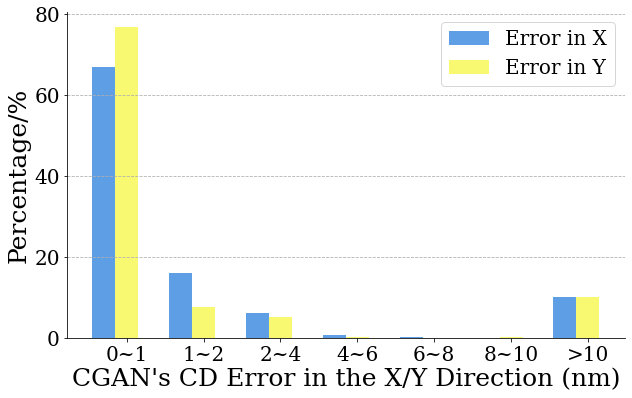

In [8]:
Err_x, Err_y = np.array([]), np.array([])
for tmp in range(len(CD_err_x)):
    Err_x = np.append(Err_x, np.array(CD_err_x[tmp]).flatten())
    Err_y = np.append(Err_y, np.array(CD_err_y[tmp]).flatten())

np.savetxt(opt.respath+"CDErr-x_cgan.csv", Err_x.flatten(), delimiter=' ')
np.savetxt(opt.respath+"CDErr-y_cgan.csv", Err_y.flatten(), delimiter=' ')
from utils.Res_plot import CD_errXY_plot
%matplotlib inline
CD_errXY_plot(Err_x, Err_y, "CGAN's ")